In [38]:
from scipy.optimize import minimize

In [39]:
from qiskit.quantum_info import SparsePauliOp



H2_op_given = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

In [40]:
H2_op_given.to_matrix()

array([[-1.06365335+0.j,  0.        +0.j,  0.        +0.j,
         0.1809312 +0.j],
       [ 0.        +0.j, -1.83696799+0.j,  0.1809312 +0.j,
         0.        +0.j],
       [ 0.        +0.j,  0.1809312 +0.j, -0.24521829+0.j,
         0.        +0.j],
       [ 0.1809312 +0.j,  0.        +0.j,  0.        +0.j,
        -1.06365335+0.j]])

In [41]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

print(service.backends())
backend = service.backend('ibm_sherbrooke')


[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_sherbrooke')>]


In [42]:
backend

<IBMBackend('ibm_sherbrooke')>

In [43]:
print(backend.configuration().processor_type)
print(backend.configuration().supported_instructions)

{'family': 'Eagle', 'revision': 3}
['ecr', 'id', 'delay', 'measure', 'reset', 'rz', 'sx', 'x', 'if_else', 'for_loop', 'switch_case']


In [44]:
# from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
# backend = FakeSherbrooke()

In [45]:
# from qiskit.primitives import Estimator
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

estimator = Estimator(backend)

In [46]:
type(estimator)

qiskit_ibm_runtime.estimator.EstimatorV2

In [47]:
import numpy as np

from qiskit.circuit.library import TwoLocal

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_algorithms.utils import algorithm_globals
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


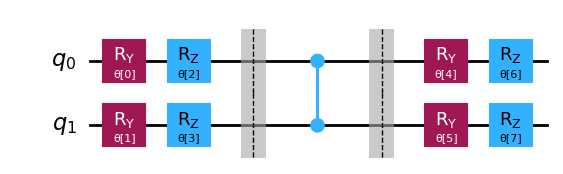

In [48]:
algorithm_globals.random_seed = 50
num_qubits = 2
rotation_blocks = ['ry','rz']
entanglement_blocks = 'cz'
entanglement = 'full'

ansatz = TwoLocal(num_qubits, rotation_blocks, entanglement_blocks,entanglement,reps=1,insert_barriers=True)

optimization_level_answer = 3
pm = generate_preset_pass_manager(backend=backend,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz)
ansatz.decompose().draw('mpl')



In [49]:
num_params = ansatz.num_parameters
num_params

8

In [50]:
# Define our Hamiltonian
H2_op = H2_op_given.apply_layout(layout=isa_circuit.layout)

In [51]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [52]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [53]:
x0 = 2 * np.pi * np.random.random(num_params)

In [54]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 1000

    res = minimize(
        cost_func,
        x0,
        args=(isa_circuit,H2_op, estimator),
        method="cobyla",
        options={'maxiter': 100}
    )

KeyError: 'field_types'

In [ ]:
import pylab
pylab.rcParams["figure.figsize"] = (12, 8)
pylab.plot(counts, values, label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

In [ ]:
import numpy as np

from qiskit.circuit.library import TwoLocal

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_algorithms.utils import algorithm_globals

# to iterate over different optimisers 
# optimizers = [COBYLA(maxiter=80)] , L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete      ");

In [ ]:
# use session now 

In [ ]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

In [ ]:
import numpy as np

from qiskit.circuit.library import TwoLocal

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_algorithms.utils import algorithm_globals

# we will iterate over these different optimizers
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete      ");

In [1]:
!pip show qiskit-algorithms

Name: qiskit-algorithms
Version: 0.3.0
Summary: Qiskit Algorithms: A library of quantum computing algorithms
Home-page: https://github.com/qiskit-community/qiskit-algorithms
Author: Qiskit Algorithms Development Team
Author-email: qiskit@us.ibm.com
License: Apache-2.0
Location: e:\program_files\anaconda3\envs\ibm_c\lib\site-packages
Requires: numpy, qiskit, scipy
Required-by: qiskit-nature
